In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
import os
import json
import random
import shutil
from ultralytics.models.yolo.detect import DetectionTrainer
import torch
from ultralytics import YOLO
import cv2
from PIL import Image
import easyocr
import matplotlib.pyplot as plt
import csv
import logging


## Distribución y conversión de etiquetado labelme a YOL0

In [ ]:

images_path = './matriculas-españolas/images'
labels_path = './matriculas-españolas/labels'
output_path = './datasets/matriculas-españolas'
sets = ['train', 'val', 'test']

# Crear carpetas para cada conjunto (train, val, test)
for set_type in sets:
    os.makedirs(os.path.join(output_path, set_type, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, set_type, 'labels'), exist_ok=True)

# Dividir archivos en 70% train, 20% val, 10% test
image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.json')])

# Asegurarse de que cada imagen tenga una etiqueta correspondiente
paired_files = [(img, lbl) for img, lbl in zip(image_files, label_files) if img.split('.')[0] == lbl.split('.')[0]]

# Mezclar y dividir los datos
random.shuffle(paired_files)
train_split = int(len(paired_files) * 0.7)
val_split = int(len(paired_files) * 0.9)

train_files = paired_files[:train_split]
val_files = paired_files[train_split:val_split]
test_files = paired_files[val_split:]

# Función para convertir coordenadas a formato YOLO
def convert_to_yolo(image_width, image_height, points):
    x_min = min([point[0] for point in points])
    x_max = max([point[0] for point in points])
    y_min = min([point[1] for point in points])
    y_max = max([point[1] for point in points])

    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height

    return x_center, y_center, width, height

# Procesar y mover archivos según su conjunto
for set_type, file_set in zip(sets, [train_files, val_files, test_files]):
    for image_file, label_file in file_set:
        # Mover imagen
        image_src = os.path.join(images_path, image_file)
        image_dst = os.path.join(output_path, set_type, 'images', image_file)
        shutil.copy2(image_src, image_dst)

        # Procesar y convertir la etiqueta
        with open(os.path.join(labels_path, label_file), 'r') as f:
            data = json.load(f)

        image_width = data['imageWidth']
        image_height = data['imageHeight']
        label_name = os.path.splitext(image_file)[0] + '.txt'
        yolo_label_path = os.path.join(output_path, set_type, 'labels', label_name)

        with open(yolo_label_path, 'w') as out_file:
            for shape in data['shapes']:
                if shape['label'] == 'matricula':
                    points = shape['points']
                    x_center, y_center, width, height = convert_to_yolo(image_width, image_height, points)
                    out_file.write(f"0 {x_center} {y_center} {width} {height}\n")

print("Distribución y conversión completadas.")


## Entrenamiento modelo detector de mattrículas

In [ ]:

# Verifica si se puede usar una GPU
print("GPU disponible: ", torch.cuda.is_available())

# Parámetros de entrenamiento para el modelo
args = dict(
    model="yolo11n.pt",  # Modelo YOLO preentrenado
    data="license_plates.yaml",  # Archivo de configuración de datos
    epochs=150,  # Aumentar el número de épocas
    batch=64,  # Tamaño del lote ajustado
    imgsz=640,  # Tamaño de imagen (ajustable según GPU)
    multi_scale=True,  # Habilita escalado múltiple para variar el tamaño de imagen
    workers=4,  # Número de trabajadores para el DataLoader
    device="cuda" if torch.cuda.is_available() else "cpu",  # Usar GPU si está disponible, de lo contrario CPU
    verbose=True,  # Mostrar progreso de entrenamiento
    lr0=0.001,  # Tasa de aprendizaje inicial ajustada
    weight_decay=0.001,  # Regularización L2
    patience=25,  # Early stopping después de 20épocas sin mejora
    augment=True,  # Habilitar aumento de datos
)

# Inicializa el entrenador y entrena el modelo
trainer = DetectionTrainer(overrides=args)  
trainer.train()

## Comprobación resultados entrenamiento

   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  16.3273         1.73477         4.59069         1.53452   
1      2  30.6906         1.12390         3.70477         1.06421   
2      3  44.3978         1.22406         2.82667         1.07593   
3      4  49.7975         1.15502         2.02121         1.03477   
4      5  63.2291         1.12518         2.02532         1.03671   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00011            0.03448           0.00006   
1               0.00333            1.00000           0.85933   
2               0.00333            1.00000           0.75590   
3               0.00333            1.00000           0.07031   
4               0.00333            1.00000           0.00722   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00002       1.25803       4.38688       1.55557  0.000120   
1              0.51223       0.88464       3

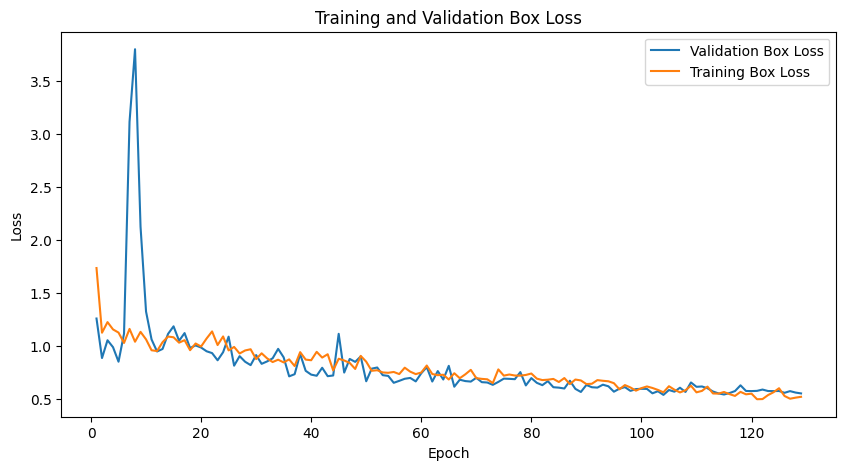

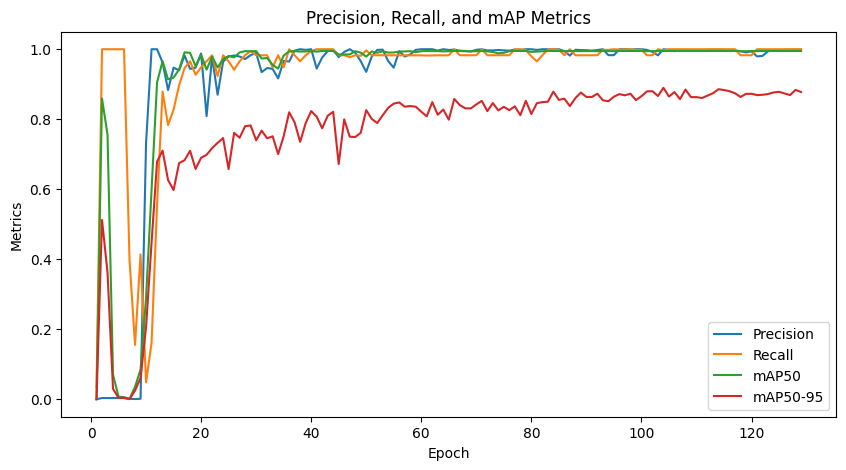

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Asegurarse de que las gráficas se muestren en el notebook
%matplotlib inline

# Leer el archivo CSV de resultados
results_csv_path = './runs/detect/train32/results.csv'
results_df = pd.read_csv(results_csv_path)

# Mostrar las primeras filas del DataFrame y las columnas disponibles
print(results_df.head())
print("Columnas disponibles:", results_df.columns)

# Verificar si las columnas necesarias existen
required_columns = ['epoch', 'val/box_loss', 'train/box_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
for col in required_columns:
    if col not in results_df.columns:
        print(f"Error: La columna {col} no existe en el DataFrame.")
        exit()

# Graficar las métricas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Training Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Box Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Precision, Recall, and mAP Metrics')
plt.show()

## Lectura de matrículas con OCR

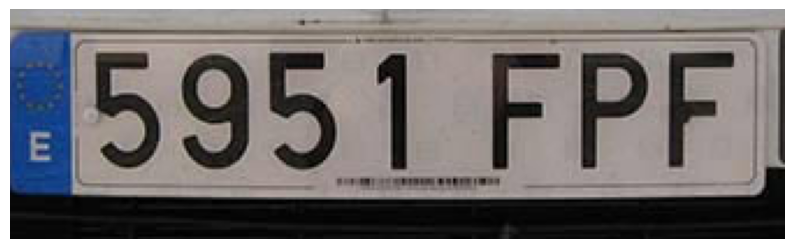

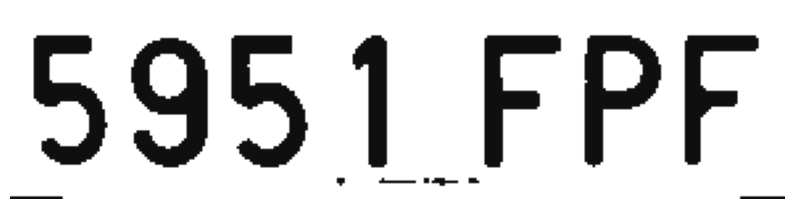

Resultado: 5951FPF, Probabilidad: 0.9998123774838661


In [ ]:

# Función para mostrar la imagen
def mostrar_imagen(imagen):
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Inicializar el lector OCR de EasyOCR
lector = easyocr.Reader(["en"], gpu=True)

def postprocesar_imagen(imagen):
    if imagen is None or imagen.size == 0:
        return None
    if len(imagen.shape) < 2 or imagen.shape[0] == 0 or imagen.shape[1] == 0:
        print("Error: La imagen no tiene las dimensiones adecuadas.")
        return None
    imagen_blur = cv2.GaussianBlur(imagen.copy(), (1, 1), 0)
    imagen_contrast = cv2.convertScaleAbs(imagen_blur, alpha=1.1, beta=15)
    return imagen_contrast

def detectar_texto(imagen_procesada):
    if imagen_procesada is None or imagen_procesada.size == 0:
        return imagen_procesada, "", 0.01
    
    resultado = lector.readtext(imagen_procesada, detail=1)
    arriba_izq = (0, 0)
    abajo_der = (0, 0)
    count = 0
    texto, probabilidad = "", 0.01

    for bbox, texto, probabilidad in resultado:
        (arriba_izq_actual, _, abajo_der_actual, _) = bbox
        arriba_izq_actual = tuple([int(val) for val in arriba_izq_actual])
        abajo_der_actual = tuple([int(val) for val in abajo_der_actual])

        if count == 0:
            arriba_izq = arriba_izq_actual
            abajo_der = abajo_der_actual
            count += 1
        else:
            abajo_der = abajo_der_actual

    if not resultado:
        return imagen_procesada, "", 0.01

    # Recortar la región de interés con las validaciones para evitar errores
    height, width = imagen_procesada.shape[:2]
    arriba_izq = (max(0, arriba_izq[0]), max(0, arriba_izq[1]))
    abajo_der = (min(width, abajo_der[0]), min(height, abajo_der[1]))

    roi_plate = imagen_procesada[arriba_izq[1]:abajo_der[1], arriba_izq[0]:abajo_der[0]]
    
    return roi_plate, texto, probabilidad

def procesar_deteccion(imagen_procesada):
    if imagen_procesada is None or imagen_procesada.size == 0:
        print("Error: Imagen procesada es None o está vacía.")
        return None, "", 0.01

    # Inicializar variables con valores predeterminados
    imagen_anterior = imagen_procesada
    texto_anterior = ""
    probabilidad_anterior = 0.01

    resultado = detectar_texto(imagen_procesada)
    # Verificar si detectar_texto devolvió resultados válidos
    if resultado:
        imagen_actual, texto_actual, probabilidad_actual = resultado
    else:
        return imagen_anterior, texto_anterior, probabilidad_anterior  # Devolver los valores iniciales si no hay detección

    # Ciclo de detección y actualización de variables
    while probabilidad_actual > probabilidad_anterior:
        probabilidad_anterior = probabilidad_actual
        imagen_anterior = imagen_actual
        texto_anterior = texto_actual
        resultado = detectar_texto(imagen_anterior)
        if resultado:
            imagen_actual, texto_actual, probabilidad_actual = resultado
        else:
            break  # Salir del bucle si no se obtienen nuevos resultados válidos

    return imagen_anterior, texto_anterior, probabilidad_anterior


def preprocesar_imagen(imagen):
    if imagen is None or imagen.size == 0:
        return None
    if len(imagen.shape) < 2 or imagen.shape[0] == 0 or imagen.shape[1] == 0:
        print("Error: La imagen no tiene las dimensiones adecuadas.")
        return None
    imagen_blur = cv2.GaussianBlur(imagen, (5, 5), 0)
    imagen_gray = cv2.cvtColor(imagen_blur, cv2.COLOR_BGR2GRAY)
    imagen_contrast = cv2.convertScaleAbs(imagen_gray, alpha=0.8, beta=10)
    _, imagen_binaria = cv2.threshold(imagen_contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return imagen_binaria

def procesar_imagen(imagen_procesada):
    if imagen_procesada is None or imagen_procesada.size == 0:
        print("Error: Imagen procesada es None o está vacía.")
        return None
    if len(imagen_procesada.shape) < 2 or imagen_procesada.shape[0] == 0 or imagen_procesada.shape[1] == 0:
        print("Error: La imagen no tiene las dimensiones adecuadas.")
        return None

    imagen_actual, texto_actual, probabilidad_actual = procesar_deteccion(imagen_procesada)
    probabilidad_anterior = 0
    imagen_anterior = ""
    texto_anterior = ""

    while probabilidad_actual > probabilidad_anterior:
        probabilidad_anterior = probabilidad_actual
        imagen_anterior = imagen_actual
        texto_anterior = texto_actual
        post_procesado = postprocesar_imagen(imagen_actual)
        
        # Agregar chequeo para evitar procesar una imagen nula
        if post_procesado is None:
            break
            
        imagen_actual, texto_actual, probabilidad_actual = procesar_deteccion(post_procesado)
    
    if probabilidad_anterior > 0.01:
        return imagen_anterior, texto_anterior, probabilidad_anterior
    else:
        return None

def OCR(imagen):
    if imagen is None or imagen.size == 0:
        print("Error: Imagen de entrada vacía.")
        return None
    if len(imagen.shape) < 2 or imagen.shape[0] == 0 or imagen.shape[1] == 0:
        print("Error: La imagen no tiene las dimensiones adecuadas.")
        return None
    if len(imagen.shape) < 3 or imagen.shape[2] != 3:
        print("Error: La imagen no tiene los canales de color necesarios.")
        return None
    imagen_preprocesada = preprocesar_imagen(imagen.copy())
    return procesar_imagen(imagen_preprocesada)

# Cargar la imagen y ejecutar OCR
image_path = "./5951FPF.png"
imagen = cv2.imread(image_path)

ocr_resultado = OCR(imagen)
if ocr_resultado:
    imagen_resultado, texto, probabilidad = ocr_resultado
    if not probabilidad:
        print("No se detectó ningún texto")
    else:
        mostrar_imagen(imagen)
        mostrar_imagen(imagen_resultado)
        print(f"Resultado: {texto}, Probabilidad: {probabilidad}")

# Procesado del video con anonimato y seguimiento de flujo

In [ ]:

logging.getLogger('ultralytics').setLevel(logging.WARNING)

# Verifica si se puede usar una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU disponible: ", torch.cuda.is_available())

# Configuración de OCR
reader = easyocr.Reader(['es'])

classNames = ["person", "bicycle", "car", "motorbike", "bus"]

datos = {name: {"from_front": [], "to_front": []} for name in classNames}

# Cargar los modelos YOLO
model_general = YOLO('yolo11n.pt')  # Modelo para detectar personas y vehículos
model_plate = YOLO('./runs/detect/train32/weights/best.pt')  # Modelo para detectar matrículas

# Configuración del archivo de video y CSV
filename = "C0142.MP4"
output_video_filename = "resultado_deteccion.mp4"
csv_filename = "resultados.csv"

# Inicializar el video y el escritor
cap = cv2.VideoCapture(filename)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out_video = cv2.VideoWriter(output_video_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Detecta procedencia del objeto
def detectar_direccion(track_id, label_name, x, frame):
    id_inside = False
    for nombre, dato in datos.items():
        if (track_id in dato["from_front"] or track_id in dato["to_front"]):
            id_inside = True
    if not id_inside:
        if label_name == "person" or label_name == "bicycle":
            if x < frame.shape[1] * 0.2 or (frame.shape[1] * 0.7 < x < frame.shape[1] * 0.95):
                datos[label_name]["to_front"].append(track_id)
            else:
                datos[label_name]["from_front"].append(track_id)
        else:
            if x < frame.shape[1] * 0.7:
                datos[label_name]["from_front"].append(track_id)
            elif x > frame.shape[1] * 0.9:
                datos[label_name]["to_front"].append(track_id)

# Preparación del archivo CSV
with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['fotograma', 'tipo_objeto', 'confianza', 'identificador_tracking', 'x1', 'y1', 'x2', 'y2',
                         'matrícula_en_su_caso', 'confianza_matricula', 'mx1', 'my1', 'mx2', 'my2', 'texto_matricula'])

    # Procesar el video con detección general
    results = model_general.track(source=filename, show=True, stream=True, verbose=False)
    frame_count = 0

    # Almacenar matrículas y sus IDs para el seguimiento con su confianza
    matrículas_seguimiento = {}

    # Iterar sobre cada resultado por frame
    for frame_result in results:
        frame_count += 1
        frame = frame_result.orig_img

        # Imprimir fotograma actual y total de fotogramas
        print(f'Procesando fotograma {frame_count}')

        # Obtener detecciones y agregar track_id de cada objeto
        for box in frame_result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            score = box.conf[0].item()
            label = int(box.cls[0])
            track_id = int(box.id[0]) if box.id is not None else -1

            if score >= 0.4:  # Umbral de confianza
                if 0 <= label < len(classNames):  # Validación de label
                    label_name = classNames[label]

                    # Aumentar el conteo para la clase correspondiente
                    detectar_direccion(track_id, label_name, x2, frame)

                    # Inicializar áreas de matrícula no difuminadas
                    non_blurred_areas = []
                    matricula_texto = "N/A"  # Variable para almacenar el texto de la matrícula
                    plate_confidence = "N/A"
                    mx1, my1, mx2, my2 = "N/A", "N/A", "N/A", "N/A"
                    
                    if label_name in ["car", "bus", "motorbike"]:
                        # Región de interés del vehículo
                        roi = frame[y1:y2, x1:x2]

                        # Usar modelo de matrículas para detectar matrículas
                        plate_results = model_plate.predict(source=roi, show=False)  

                        # Procesar los resultados de matrículas
                        for plate_result in plate_results:
                            for plate_box in plate_result.boxes:
                                plate_x1, plate_y1, plate_x2, plate_y2 = map(int, plate_box.xyxy[0])
                                plate_score = plate_box.conf[0].item()
                                
                                if plate_score >= 0.3:  # Umbral de confianza para matrículas
                                    # Guardar región de la matrícula sin difuminar
                                    non_blurred_areas.append(((plate_x1 + x1, plate_y1 + y1), (plate_x2 + x1, plate_y2 + y1)))

                                    # Leer el texto de la matrícula
                                    roi_plate = roi[plate_y1:plate_y2, plate_x1:plate_x2]
                                    if roi_plate is None or roi_plate.size == 0 or len(imagen.shape) < 2 or roi_plate.shape[0] == 0 or roi_plate.shape[1] == 0:
                                        print("Error: La región de interés (ROI) de la matrícula está vacía.")
                                    else:
                                        ocr_results_plate = OCR(roi_plate)    
                                    if ocr_results_plate:
                                        imagen_resultado, matricula_texto, ocr_confianza = ocr_results_plate

                                        # Almacenar solo la matrícula con mayor confianza
                                        if (track_id not in matrículas_seguimiento) or \
                                            (ocr_confianza > matrículas_seguimiento[track_id][1]) or \
                                            (abs(len(matricula_texto)-8) > abs(len(matrículas_seguimiento[track_id][0])-8)):
                                            matrículas_seguimiento[track_id] = (matricula_texto, ocr_confianza)
                                            print(f'Matrícula detectada en fotograma {frame_count}: {matricula_texto} con confianza {ocr_confianza}')

                                    # Obtener la matrícula de mayor confianza para el CSV
                                    texto_matricula = matrículas_seguimiento[track_id][0] if track_id in matrículas_seguimiento else "N/A"

                                    # Dibujar el perímetro de la matrícula en verde
                                    cv2.rectangle(frame, (plate_x1 + x1, plate_y1 + y1), (plate_x2 + x1, plate_y2 + y1), (0, 255, 0), 2)
                                    # Mostrar el texto de la matrícula debajo del nombre de la clase del vehículo
                                    cv2.putText(frame, matricula_texto, (x1, y1 - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                    # Aplicar desenfoque en el ROI sin afectar el texto ya insertado
                    roi_blurred = cv2.GaussianBlur(frame[y1:y2, x1:x2], (51, 51), 0)
                    for (plate_x1, plate_y1), (plate_x2, plate_y2) in non_blurred_areas:
                        # Restaurar la región de matrícula sin difuminar
                        roi_blurred[plate_y1 - y1:plate_y2 - y1, plate_x1 - x1:plate_x2 - x1] = frame[y1:y2, x1:x2][plate_y1 - y1:plate_y2 - y1, plate_x1 - x1:plate_x2 - x1]
                    frame[y1:y2, x1:x2] = roi_blurred

                    # Difuminar toda el área de personas
                    if label_name == "person":
                        roi = frame[y1:y2, x1:x2]
                        roi_blurred = cv2.GaussianBlur(roi, (51, 51), 0)
                        frame[y1:y2, x1:x2] = roi_blurred

                    # Dibujar el rectángulo y mostrar ID de seguimiento
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
                    cv2.putText(frame, label_name, (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

                    # Agregar el texto de la matrícula después de desenfocar
                    if matricula_texto != "N/A":
                        for (plate_x1, plate_y1), _ in non_blurred_areas:
                            cv2.putText(frame, matricula_texto, (plate_x1, plate_y1 - 10), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                    # Guardar el registro en el CSV para todas las detecciones
                    csv_writer.writerow([frame_count, label_name, score, track_id, x1, y1, x2, y2,
                                         "matrícula" if label_name in ["car", "bus", "motorbike"] else "N/A",
                                         plate_confidence, mx1, my1, mx2, my2, matricula_texto])

        out_video.write(frame)

cap.release()
out_video.release()

# Mostrar conteo de clases
conteo_clases = 0
for objeto, data in datos.items():
    conteo_clases += len(data["from_front"]) + len(data["to_front"])
    print(f"{objeto}: \n\t{len(data['from_front'])} vienen de frente, \n\t{len(data['to_front'])} vienen de atrás, \n\ttotal: {len(data['from_front']) + len(data['to_front'])}")
print("Conteo total de objetos: ", conteo_clases)

GPU disponible:  True
Procesando fotograma 1
Procesando fotograma 2
Procesando fotograma 3
Procesando fotograma 4
Procesando fotograma 5
Procesando fotograma 6
Procesando fotograma 7
Procesando fotograma 8
Procesando fotograma 9
Procesando fotograma 10
Procesando fotograma 11
Procesando fotograma 12
Procesando fotograma 13
Procesando fotograma 14
Procesando fotograma 15
Procesando fotograma 16
Procesando fotograma 17
Procesando fotograma 18
Procesando fotograma 19
Procesando fotograma 20
Procesando fotograma 21
Procesando fotograma 22
Procesando fotograma 23
Procesando fotograma 24
Procesando fotograma 25
Procesando fotograma 26
Procesando fotograma 27
Procesando fotograma 28
Procesando fotograma 29
Procesando fotograma 30
Procesando fotograma 31
Procesando fotograma 32
Procesando fotograma 33
Procesando fotograma 34
Procesando fotograma 35
Procesando fotograma 36
Procesando fotograma 37
Procesando fotograma 38
Procesando fotograma 39
Procesando fotograma 40
Procesando fotograma 41
Pro